In [1]:
import sklearn
import os 
import tifffile
from sklearn.feature_extraction import image
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.cluster import KMeans
from scipy.spatial import distance
import os
import sys
import sknetwork as skn
from sklearn.cluster import SpectralClustering


In [2]:
## Load the tile
## we will not use utils get band as having a array is better here 

def get_array(folder):
    # we want all the bands to create the dataset
    L = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
    path = 'data/'+ folder
    inside_folder = os.listdir(path)

    # store the bands
    band_array = np.zeros((600,1400,len(L)))
    #band_array = np.zeros((84,183,len(L)))
    ## load wanted spectral bands
    i = 0
    for raw_band in inside_folder:
        for desired_band in L:
            if desired_band in raw_band:
                img = tifffile.imread(os.path.join(path,raw_band))
                # crop the image not to have problems when creating patchs
                band_array[:,:,i] = img[:600,:1400]
                #band_array[:,:,i] = img
                i+=1
    return band_array

img = get_array('Mytilene/M1')[:,:,[1,2,3,7]]

In [5]:
def kmeans(arrays, nb_clust):
    arrays_flat=np.array([arrays[:,:,i].flatten() for i in range(arrays.shape[2])])
    X=(np.transpose(arrays_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=1000) # tester k-means méthod max?
    kmeans.fit(X)
    labels=kmeans.labels_
    clust = kmeans.cluster_centers_
    plastic_index = 0
    nb = 99999
    nb_2 = 0
    img_labels = labels.reshape(600,1400)
    #img_labels = labels.reshape(84,183)
    
    plt.figure()
    plt.imshow(img_labels)
    plt.title('labels after kmeans')
    
    return img_labels,clust

In [7]:
def delete_land(img):
    labels,clust = kmeans(img, 2)
    spectral_sign = {'water': [ 0.10384066, 0.13632251, 0.16474463, 
       0.3045134], 'ground':[ 0.03796409, 0.03244987, 0.02011696, 0.01891139]
                    ,'plastic' : [0.03825 , 0.037625, 0.0334 , 0.055125]}
    d1 = distance.euclidean(clust[0], spectral_sign['ground'])
    d2 = distance.euclidean(clust[1], spectral_sign['ground'])
    ground_label = 100
     
    if d1<d2:
        ground_label = 1
    else : 
        ground_label = 0
        
    result = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if labels[i,j] == ground_label :
                result[i,j] = spectral_sign['water']
                #result[i,j+1] = spectral_sign['water']
                #result[i,j+2] = spectral_sign['water']

    plt.figure()  
    
    plt.imshow(result[:,:,0])
    plt.title('result')
    return result

    
    

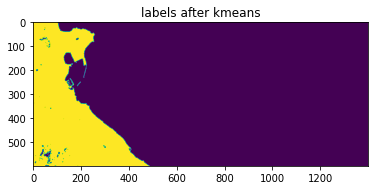

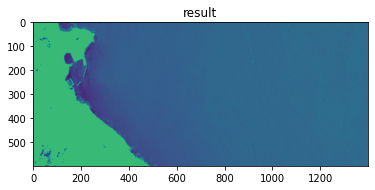

In [9]:
result0 = delete_land(img)

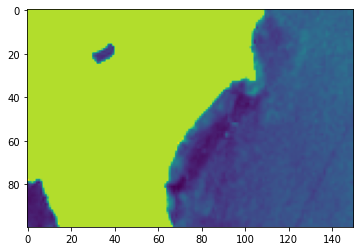

In [10]:
result = result0[50:150,150:300,:].copy()



In [13]:
from sklearn.decomposition import PCA

def perform_pca(X,n):
    pca = PCA(n_components=n, whiten = False)
    Xpca = pca.fit_transform(X )
    return(Xpca)

In [16]:
arrays_flat=np.array([result[:,:,i].flatten() for i in range(result.shape[2])])
X =(np.transpose(arrays_flat))
#X = perform_pca(X,0.6)



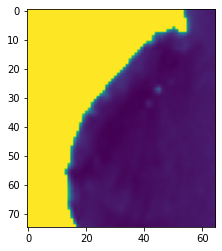

In [20]:
#plt.imshow(X.reshape(84,83))
plt.imshow(X.reshape(75,65)[:,:])

In [21]:
nb_cluster = 2
clustering0 = SpectralClustering(n_clusters=nb_cluster, n_components = 10, affinity = 'nearest_neighbors' ,  n_neighbors = 150).fit(X)

In [23]:
#img_labels0 = clustering0.labels_.reshape(84,83)
img_labels0 = clustering0.labels_.reshape(75,65)




for i in range(5,15,1):
    clustering0 = SpectralClustering(n_clusters=nb_cluster, n_components = i, affinity = 'nearest_neighbors' ,  n_neighbors = 50).fit(X)
    img_labels0 = clustering0.labels_.reshape(100,60)
    plt.figure(figsize = (100,100))
    plt.subplot(121)
    plt.imshow(img_labels0[:,:])
    plt.subplot(122)
    plt.imshow(result[:,:,1])

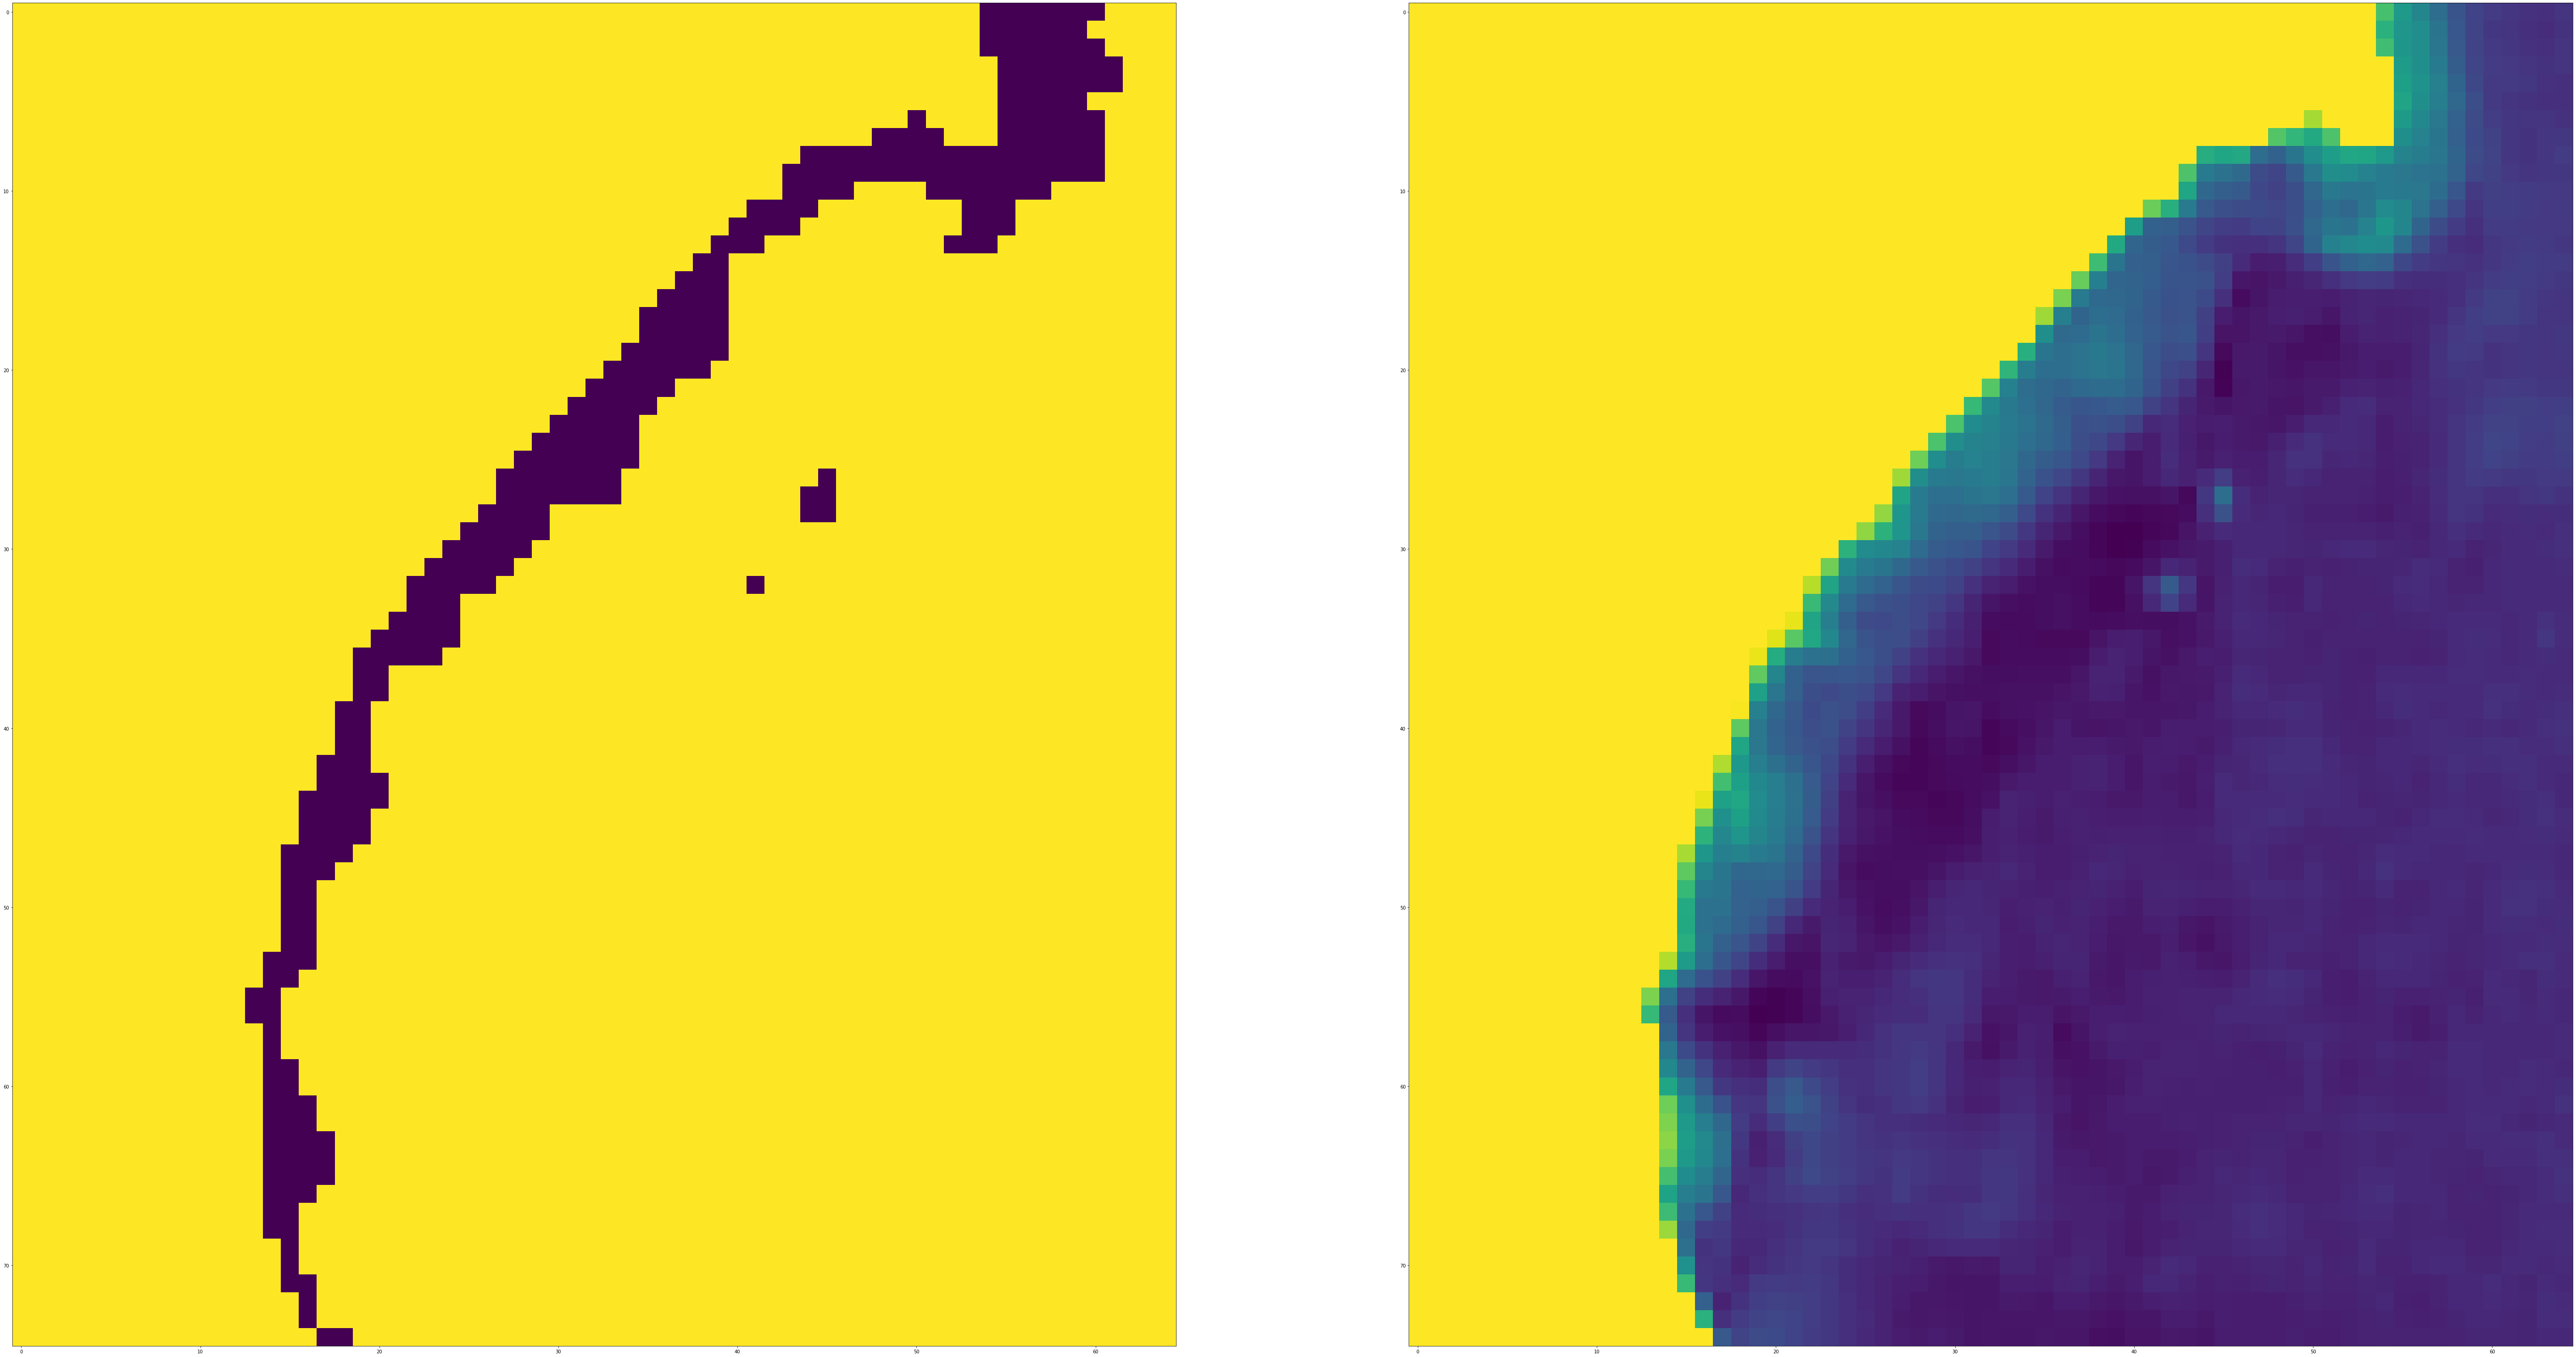

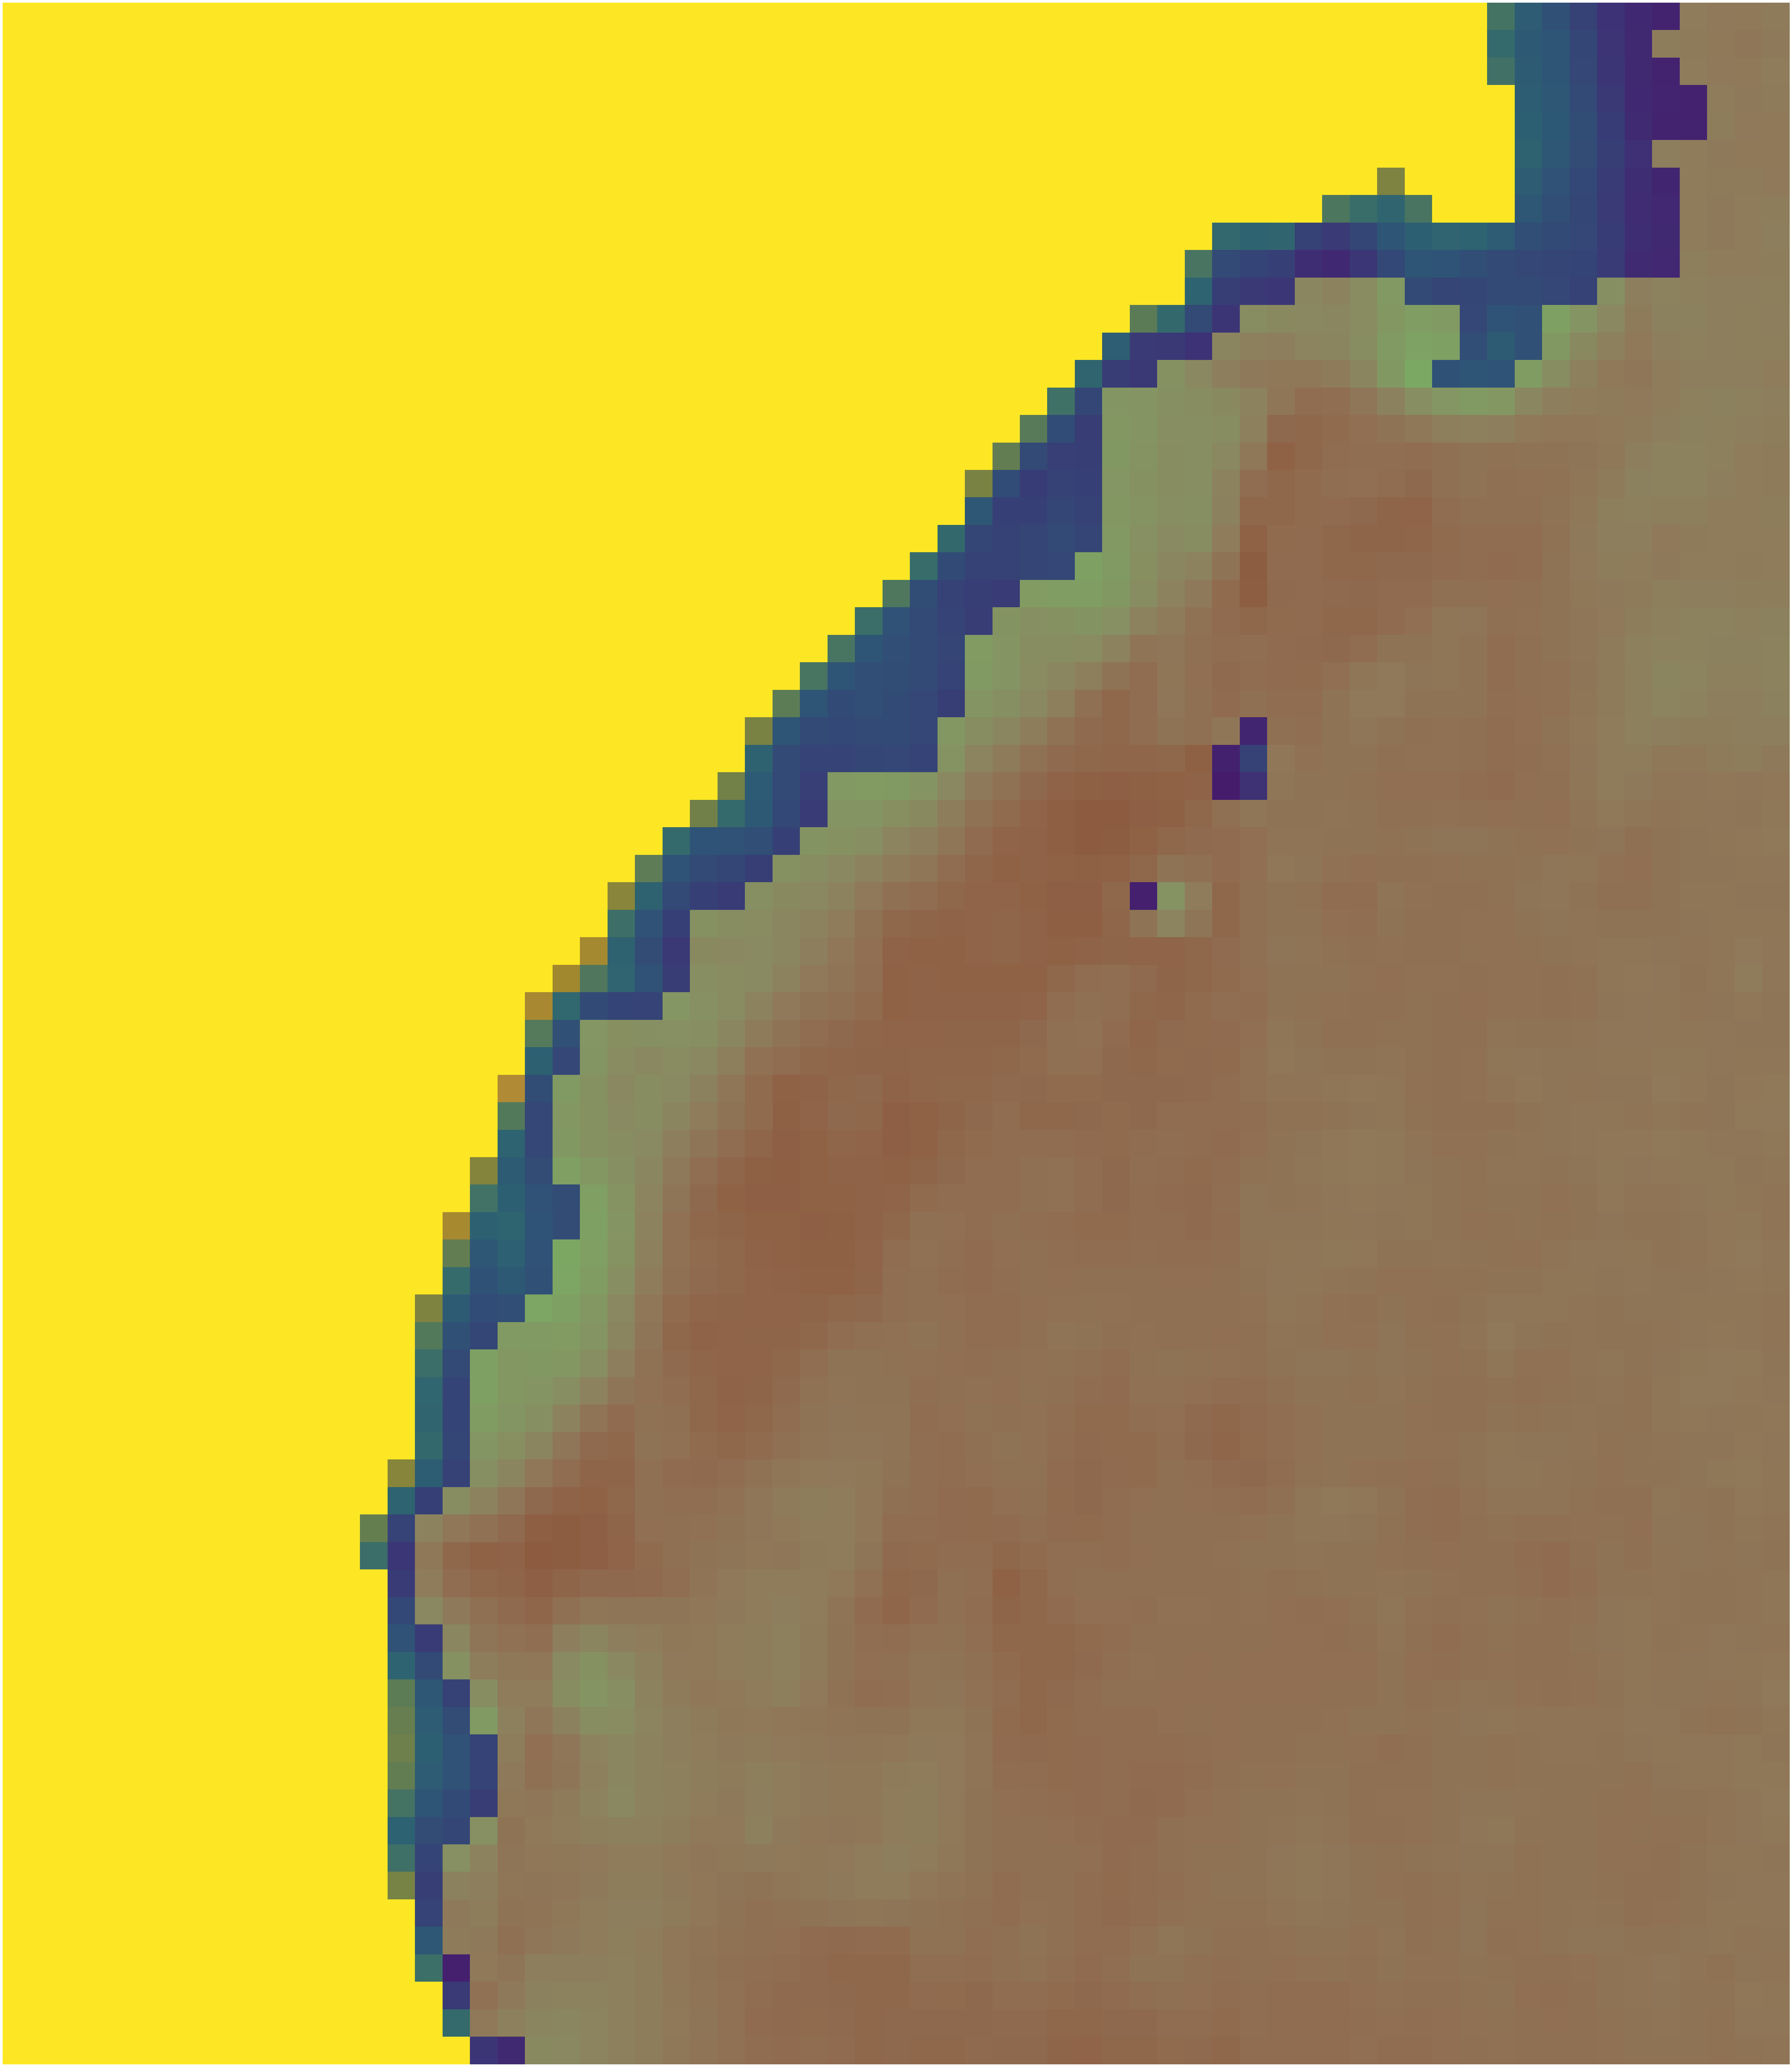

In [24]:
plt.figure(figsize = (100,100))
plt.subplot(121)
plt.imshow(img_labels0[:,:])
plt.subplot(122)
plt.imshow(result[:,:,1])
plt.imsave('spectral clustering.jpg',img_labels0)

fig, ax = plt.subplots(figsize = (100,100))
ax.imshow(result[:,:,1])
ax.imshow(img_labels0[:,:], alpha=0.4)
ax.set_axis_off()